In [1]:
#!/usr/bin/env python
# coding: utf-8

import os, sys
import logging
import numpy as np

import xarray as xr
import xarray.ufuncs as xu
import xrft
import pandas as pd

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy

from cross_defPlot import *
from cross_compute import *

from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4, silence_logs='error', protocol = 'tcp://',
                      host = '137.129.155.67')
client = Client(cluster)
client

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32923 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://137.129.155.67:32923/status,
Dashboard: http://137.129.155.67:32923/status,Workers: 1
Total threads: 4,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: tcp://137.129.155.67:47537,Workers: 1
Dashboard: http://137.129.155.67:32923/status,Total threads: 4
Started: Just now,Total memory: 78.61 GiB
Comm: tcp://137.129.155.67:42673,Total threads: 4
Dashboard: http://137.129.155.67:38095/status,Memory: 78.61 GiB
Nanny: None,


In [40]:
season = 'JAS'
indir_VAR = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/ANALYSIS/VARIANCE/ANOMALY_FILTERED/'
ds_VAR_OLR = xr.open_mfdataset(indir_VAR + 'OLR_' + season + '_box_INDO.nc', parallel=True)
ds_VAR_TCWV = xr.open_mfdataset(indir_VAR + 'TCWV_'+ season + '_box_INDO.nc', parallel=True)
ds_VAR = xr.merge([ds_VAR_OLR, ds_VAR_TCWV])

### Compute standard deviation
ds_std_mean = (ds_VAR**(0.5)).persist()
for w in wave:
    ds_FILTER = addNegative(ds_FILTER, ds_std_mean, w)
    
ds_FILTER = ds_FILTER
ds_FILTER

<xarray.Dataset>
Dimensions:            (time: 744)
Coordinates:
  * time               (time) datetime64[ns] 2009-07-01 ... 2009-10-01T21:00:00
Data variables: (12/38)
    TCWV_Kelvin        (time) float64 -0.3333 -0.4574 -0.5949 ... 0.1978 0.3418
    TCWV_Rossby        (time) float64 -1.296 -1.401 -1.504 ... 0.9983 0.9802
    TCWV_MJO           (time) float64 1.321 1.343 1.365 ... 0.6333 0.6419 0.6503
    TCWV_MRG           (time) float64 -0.5633 -0.6168 -0.664 ... 0.5172 0.6803
    TCWV_EIG           (time) float64 ...
    TCWV_WIG           (time) float64 ...
    ...                 ...
    STD_OLR_Kelvin     (time) float64 7.62 7.62 7.62 7.62 ... 7.62 7.62 7.62
    STD_OLR_Kelvin_N   (time) float64 -7.62 -7.62 -7.62 ... -7.62 -7.62 -7.62
    STD_OLR_Rossby     (time) float64 8.434 8.434 8.434 ... 8.434 8.434 8.434
    STD_OLR_Rossby_N   (time) float64 -8.434 -8.434 -8.434 ... -8.434 -8.434
    STD_OLR_MRG        (time) float64 7.334 7.334 7.334 ... 7.334 7.334 7.334
    STD_OLR_MRG_N      (time) float64 -7.334 -7.334 -7.334 ... -7.334 -7.334

In [2]:
wave_TCWV = ['TCWV_TD', 'TCWV_MJO', 'TCWV_Kelvin', 'TCWV_Rossby', 'TCWV_MRG']  
wave_OLR = ['OLR_TD', 'OLR_MJO', 'OLR_Kelvin', 'OLR_Rossby', 'OLR_MRG']

wave = np.concatenate((wave_TCWV, wave_OLR), axis =0 )
coeff = 1

# Series temporelle.
On moyenne chaque variable spatialement sur une boite entre 9 °N et 19°N, et entre 5 °N et 15 °N, puis on plot les séries temporelles.

In [35]:
ds_FILTER = xr.open_dataset('/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/ANALYSIS/BOXINDO/mean_OLR_TCWV_wave.nc')
ds_FILTER

<xarray.Dataset>
Dimensions:            (time: 744)
Coordinates:
  * time               (time) datetime64[ns] 2009-07-01 ... 2009-10-01T21:00:00
Data variables: (12/38)
    TCWV_Kelvin        (time) float64 ...
    TCWV_Rossby        (time) float64 ...
    TCWV_MJO           (time) float64 ...
    TCWV_MRG           (time) float64 ...
    TCWV_EIG           (time) float64 ...
    TCWV_WIG           (time) float64 ...
    ...                 ...
    STD_OLR_Kelvin     (time) float64 ...
    STD_OLR_Kelvin_N   (time) float64 ...
    STD_OLR_Rossby     (time) float64 ...
    STD_OLR_Rossby_N   (time) float64 ...
    STD_OLR_MRG        (time) float64 ...
    STD_OLR_MRG_N      (time) float64 ...

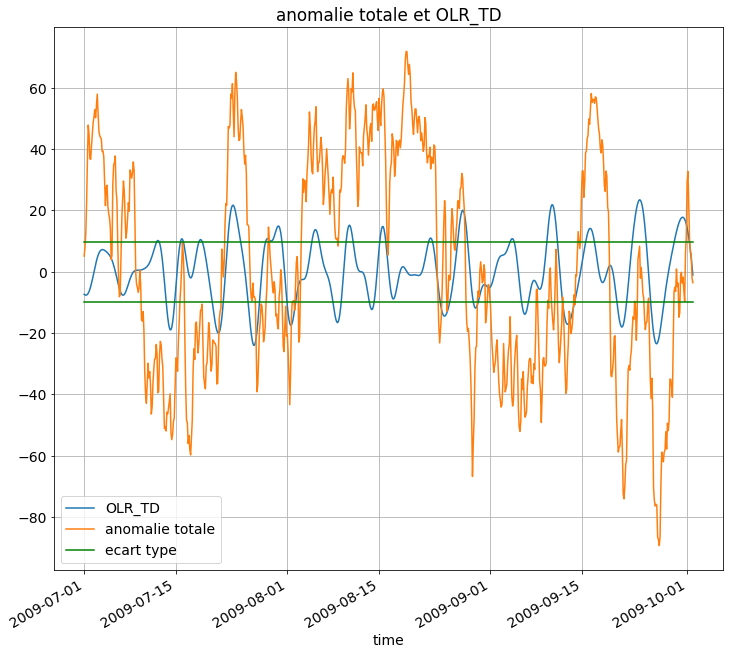

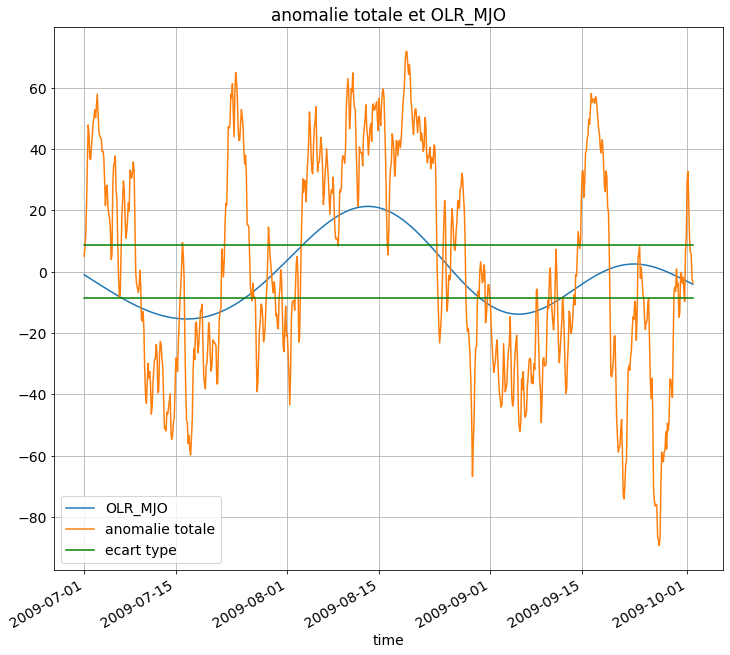

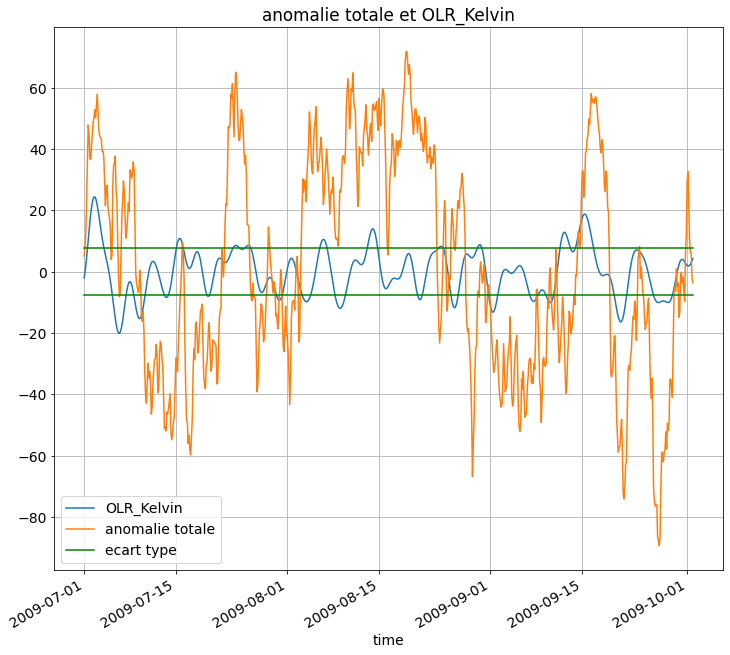

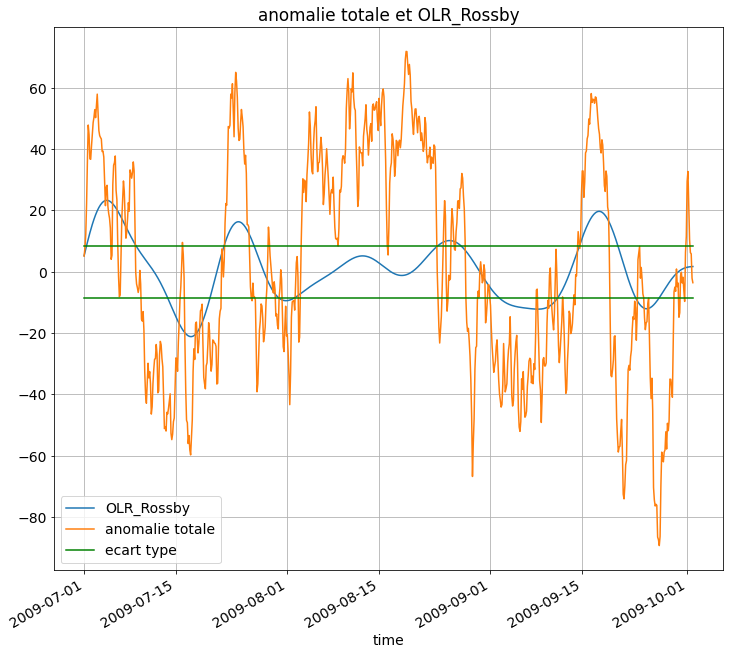

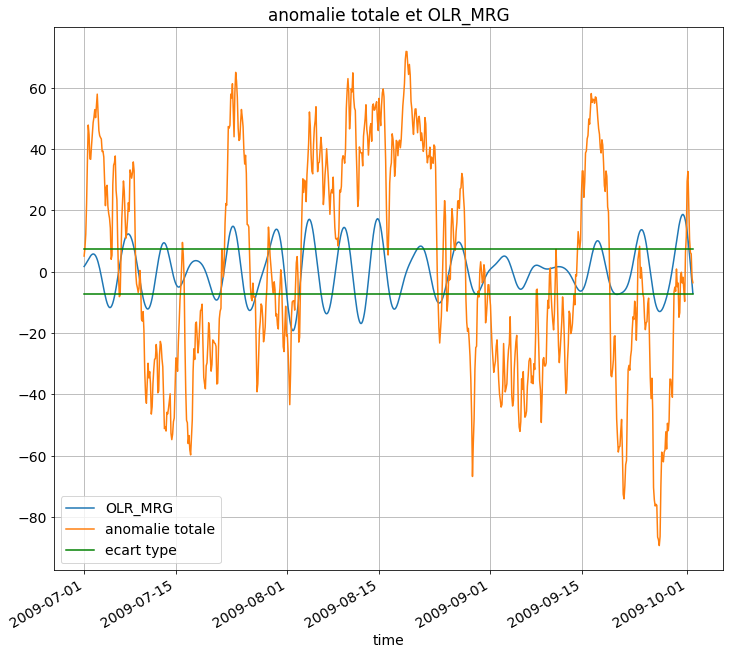

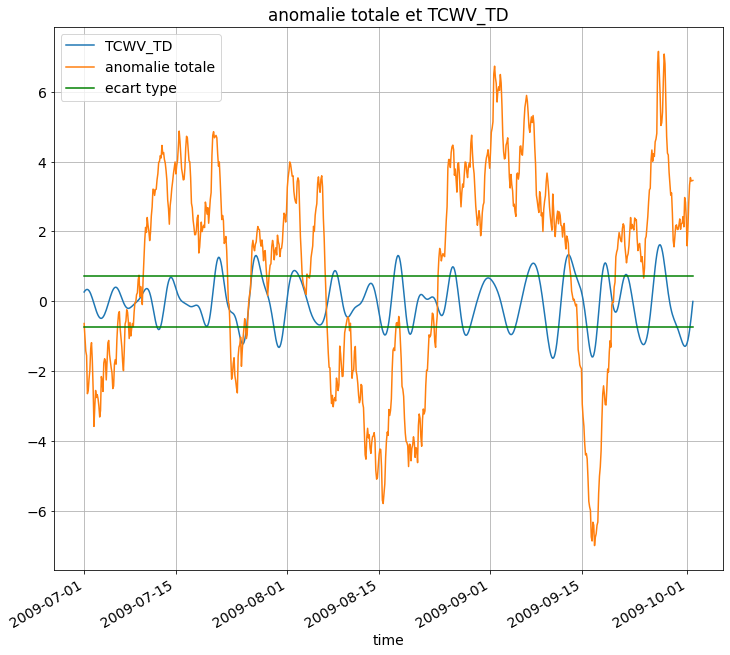

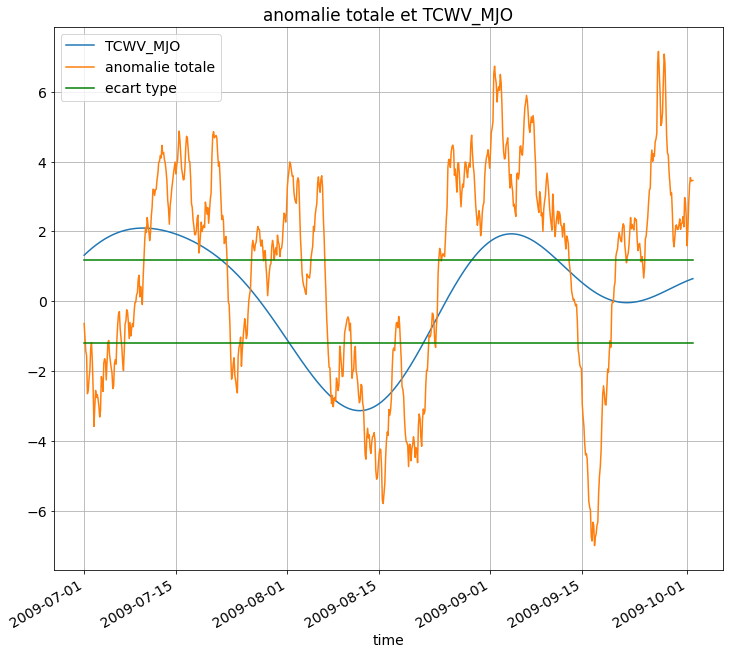

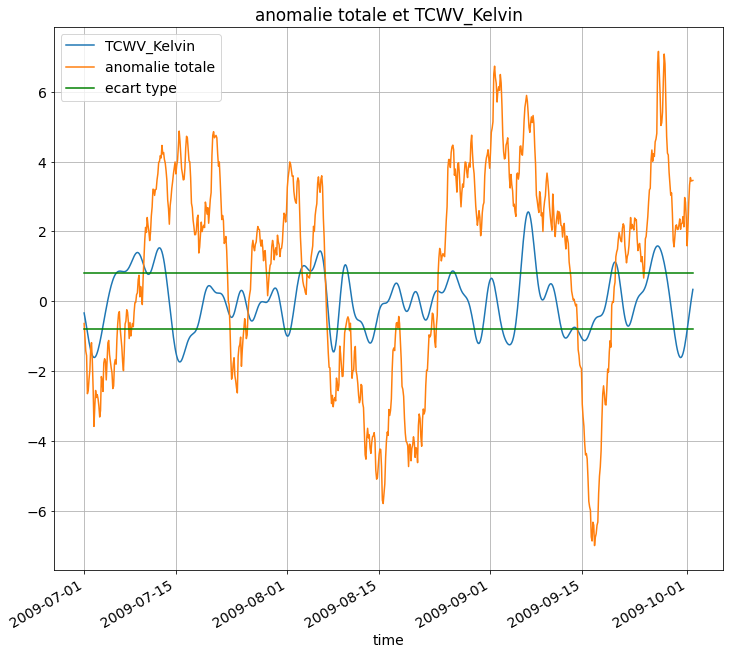

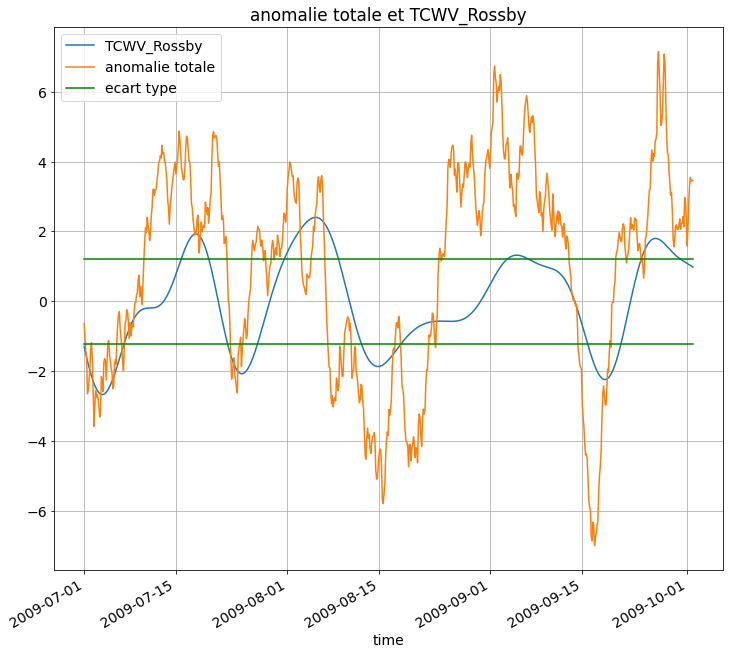

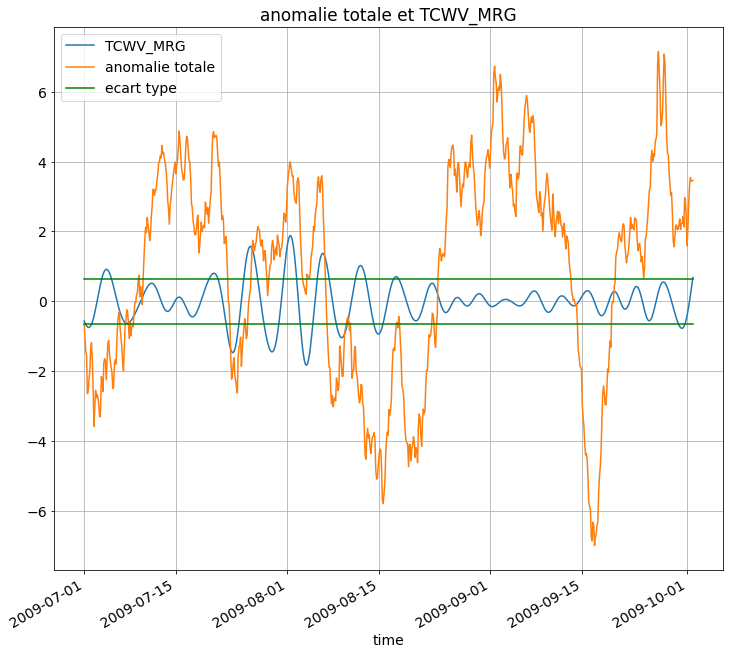

In [37]:
def plotline1D_mean(ds_FILTER, wave, ano):
    da_plot = ds_FILTER[wave]
    plt.rc("figure", figsize=(12,10))
    plt.figure()
    da_plot.plot(label = wave)
    ds_FILTER[ano].plot(label = 'anomalie totale')
    ds_FILTER['STD_'+ wave].plot(label = 'ecart type', color = 'green')
    ds_FILTER['STD_'+ wave + '_N'].plot(color = 'green')
    plt.legend()
    plt.ylabel('')
    plt.grid()

for w in wave_OLR:
    plotline1D_mean(ds_FILTER, w, 'OLR_ano')
    plt.title('anomalie totale et ' + w)

for w in wave_TCWV:
    plotline1D_mean(ds_FILTER, w, 'tcwv_ano')
    plt.title('anomalie totale et ' + w)

In [5]:
def plotallline1D_mean(ds_FILTER, lat_Sel, lon_Sel, wave):
    colors = ['b','g','r','c','m','y','k','orange']
    i = 0
    plt.rc("figure", figsize=(12,10))
    plt.figure()
    for w in wave :
        da_plot = ds_FILTER[w]
        da_plot.plot(label = w, color = colors[i])
        ds_FILTER['STD_'+ w].plot(label = 'ecart type' + w, color = colors[i])
        ds_FILTER['STD_'+ w + '_N'].plot(color = colors[i])
        i = i + 1
        print(i)
    plt.legend()
    plt.ylabel('')
    plt.grid()

# plotallline1D_mean(ds_FILTER, latitude, longitude, wave_TCWV)
# plotallline1D_mean(ds_FILTER, latitude, longitude, wave_OLR)


### On ne garde que les données au-dessus ou en-dessous de l'ecart type, qu'on appelle phase active de l'onde ou phase non-active.
La phase active permet de savoir si l'onde contribue à la diminution de l'anomalie pour l'OLR. La phase non active à son augmentation. 
### On sépare en trois chaque phase active ou non active.
En phase croissante, décroissante et maximum

In [19]:
### Compute of gradient
folderBox = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/ANALYSIS/BOXINDO/'
ds_FILTER = xr.open_dataset(folderBox + 'mean_OLR_TCWV_wave.nc')

In [38]:
def keepData(ds, coeff, wave_REF):
    _ds = ds.load()
    _ds[wave_REF] = xr.where( ((ds[wave_REF] <= (ds['STD_' + wave_REF +'_N'] * coeff)) | 
                                   (ds[wave_REF] >= (ds['STD_' + wave_REF] * coeff))) == True,
                                   _ds[wave_REF], np.nan)
    return _ds.compute()

def keepData_GRAD(ds, ds_GRAD, coeff, wave_REF):
    _ds_GRAD = ds_GRAD.load()
    _ds_GRAD[wave_REF] = xr.where( ((ds[wave_REF] <= (ds['STD_' + wave_REF +'_N'] * coeff)) | 
                                   (ds[wave_REF] >= (ds['STD_' + wave_REF] * coeff))) == True,
                                   _ds_GRAD[wave_REF], np.nan)
    return ds_GRAD

In [39]:
coeff = 1
for w in wave:
    ds_FILTER_keep = keepData(ds_FILTER, coeff, w)
    
    
ds_FILTER = xr.open_dataset(folderBox + 'mean_OLR_TCWV_wave.nc')

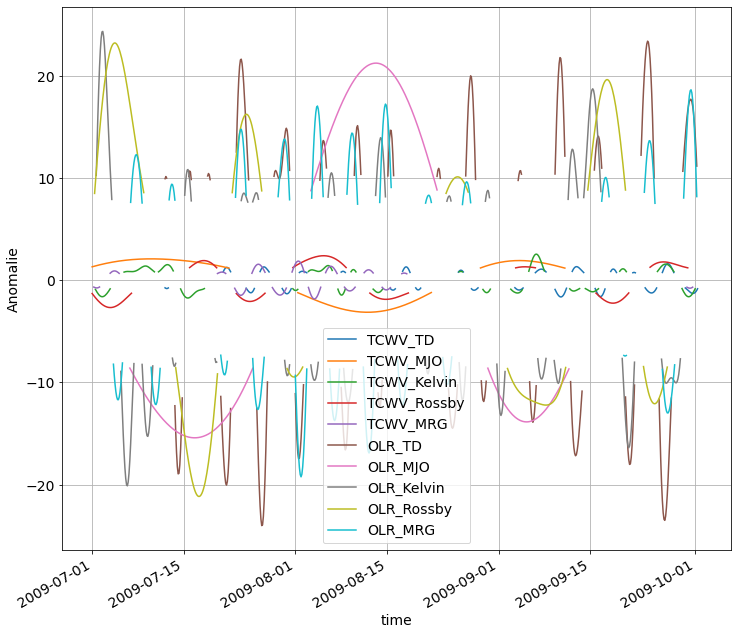

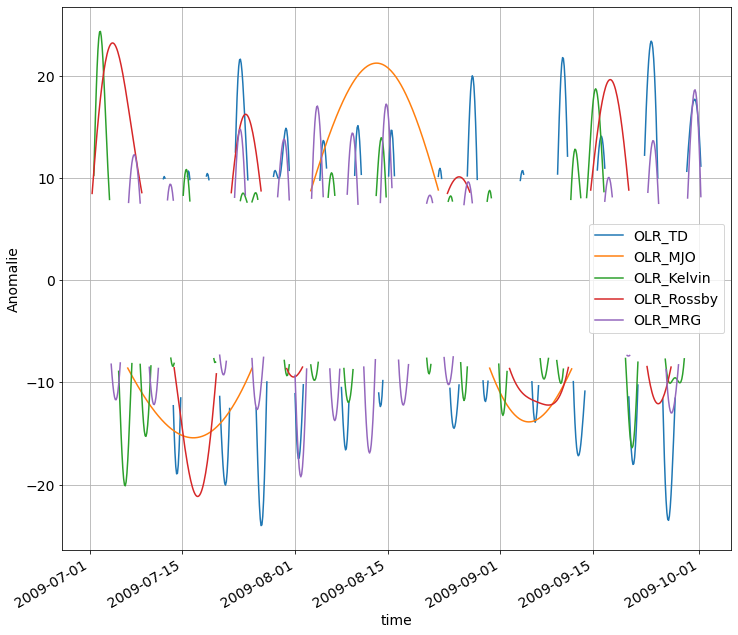

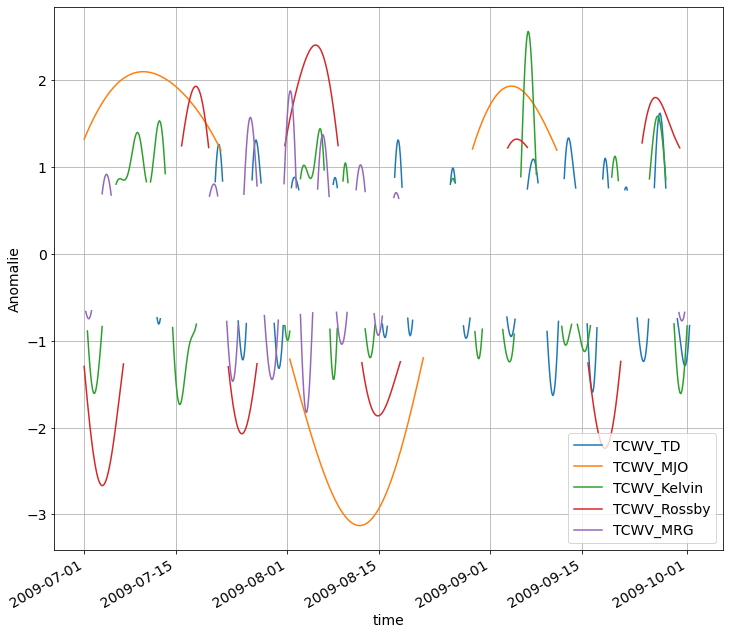

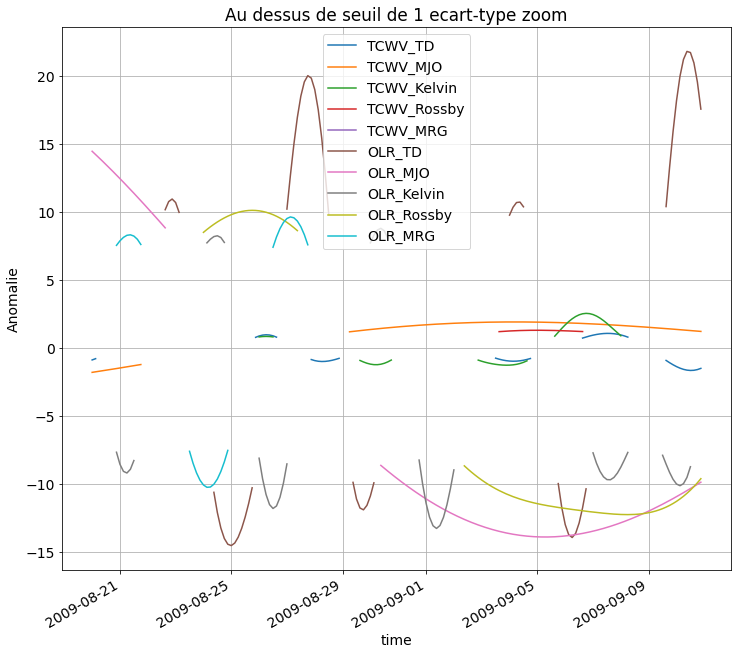

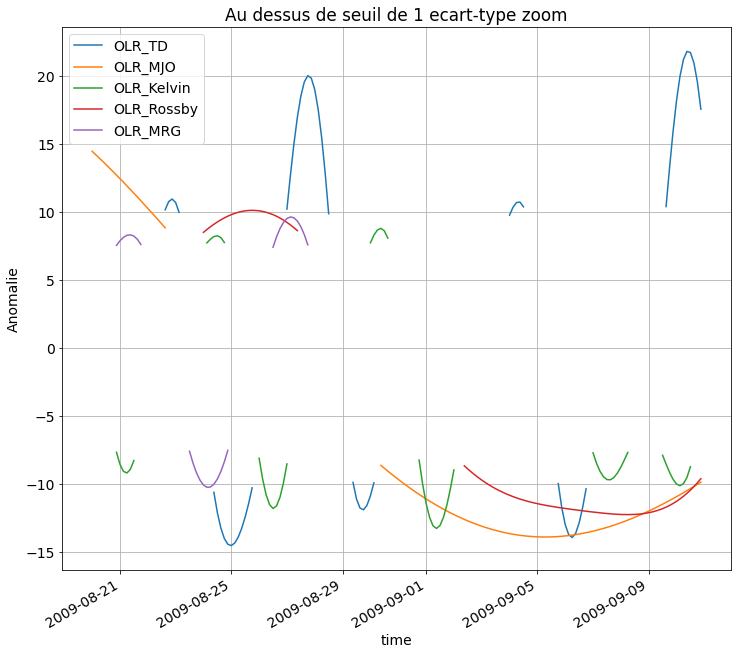

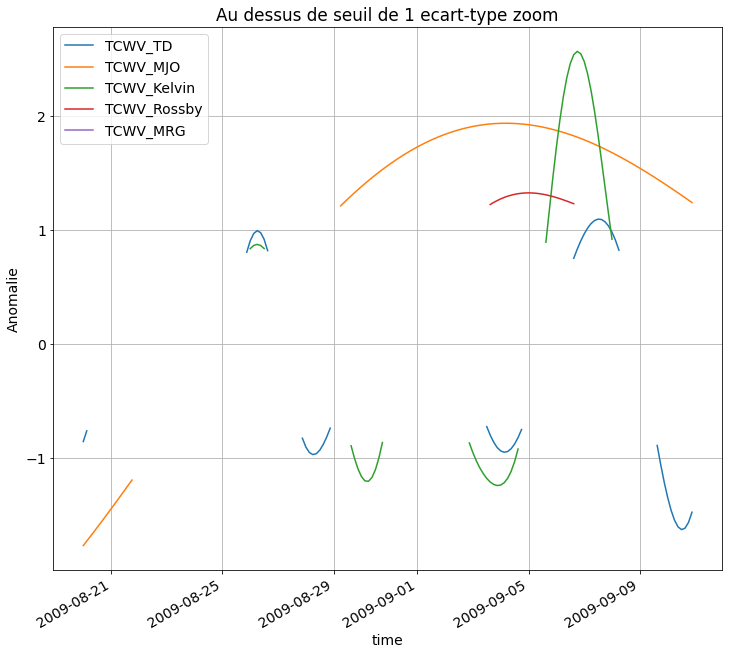

In [41]:
plt.figure()
for w in wave :
    ds_FILTER_keep[w].plot(label = w)
# ds_FILTER_keep['OLR_ano'].plot(label = 'anomalie')
plt.grid()
plt.ylabel('Anomalie')
plt.legend()
plt.show()

plt.figure()
for w in wave_OLR :
    ds_FILTER_keep[w].plot(label = w)
# ds_FILTER_keep['OLR_ano'].sel(time = slice('2009-09-15','2009-10-01')).plot(label = 'anomalie')
plt.grid()
plt.ylabel('Anomalie')
plt.legend()
plt.show()

plt.figure()
for w in wave_TCWV :
    ds_FILTER_keep[w].plot(label = w)
# ds_FILTER_keep['OLR_ano'].sel(time = slice('2009-09-15','2009-10-01')).plot(label = 'anomalie')
plt.grid()
plt.ylabel('Anomalie')
plt.legend()
plt.show()


plt.figure()
for w in wave :
    ds_FILTER_keep[w].sel(time = slice('2009-08-20','2009-09-10')).plot(label = w)
# ds_FILTER_keep['OLR_ano'].plot(label = 'anomalie')
plt.grid()
plt.ylabel('Anomalie')
plt.title('Au dessus de seuil de 1 ecart-type zoom')
plt.legend()
plt.show()


plt.figure()
for w in wave_OLR :
    ds_FILTER_keep[w].sel(time = slice('2009-08-20','2009-09-10')).plot(label = w)
# ds_FILTER_keep['OLR_ano'].sel(time = slice('2009-09-15','2009-10-01')).plot(label = 'anomalie')
plt.grid()
plt.ylabel('Anomalie')
plt.title('Au dessus de seuil de 1 ecart-type zoom')
plt.legend()
plt.show()

plt.figure()
for w in wave_TCWV :
    ds_FILTER_keep[w].sel(time = slice('2009-08-20','2009-09-10')).plot(label = w)
# ds_FILTER_keep['OLR_ano'].sel(time = slice('2009-09-15','2009-10-01')).plot(label = 'anomalie')
plt.grid()
plt.ylabel('Anomalie')
plt.title('Au dessus de seuil de 1 ecart-type zoom')
plt.legend()
plt.show()

In [23]:
ds_FILTER = xr.open_dataset('/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/ANALYSIS/BOXAFRIQUE/mean_OLR_TCWV_wave.nc')
ds_FILTER_G = ds_FILTER.chunk({'time' : -1}).differentiate('time', datetime_unit = "s").compute()
for w in wave:
    ds_FILTER_G_keep = keepData_GRAD(ds_FILTER, ds_FILTER_G, coeff, w)


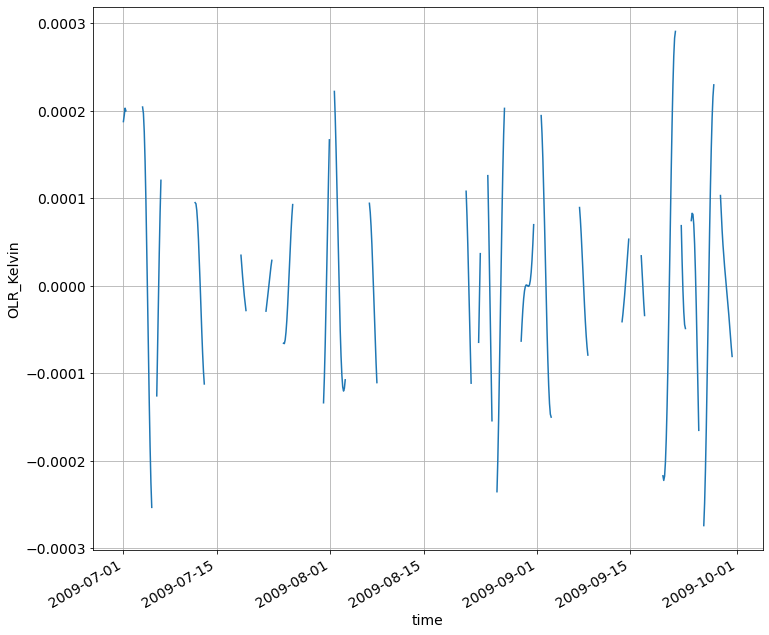

In [24]:
ds_FILTER_G = ds_FILTER.chunk({'time' : -1}).differentiate('time', datetime_unit = "s").compute()
plt.figure()
ds_FILTER_G_keep.OLR_Kelvin.plot()
plt.grid()
plt.show()

In [25]:
ds_FILTER_keep

<xarray.Dataset>
Dimensions:            (time: 744)
Coordinates:
  * time               (time) datetime64[ns] 2009-07-01 ... 2009-10-01T21:00:00
Data variables: (12/38)
    TCWV_Kelvin        (time) float64 nan nan nan -0.7403 ... nan nan nan nan
    TCWV_Rossby        (time) float64 nan nan nan nan -1.702 ... nan nan nan nan
    TCWV_MJO           (time) float64 1.321 1.343 1.365 1.387 ... nan nan nan
    TCWV_MRG           (time) float64 nan nan nan nan nan ... nan nan nan nan
    TCWV_EIG           (time) float64 0.1617 0.192 0.123 ... 0.0663 0.1125
    TCWV_WIG           (time) float64 0.1183 -0.0159 -0.136 ... 0.07486 0.05324
    ...                 ...
    STD_OLR_Kelvin     (time) float64 7.187 7.187 7.187 ... 7.187 7.187 7.187
    STD_OLR_Kelvin_N   (time) float64 -7.187 -7.187 -7.187 ... -7.187 -7.187
    STD_OLR_Rossby     (time) float64 6.235 6.235 6.235 ... 6.235 6.235 6.235
    STD_OLR_Rossby_N   (time) float64 -6.235 -6.235 -6.235 ... -6.235 -6.235
    STD_OLR_MRG        (time) float64 5.224 5.224 5.224 ... 5.224 5.224 5.224
    STD_OLR_MRG_N      (time) float64 -5.224 -5.224 -5.224 ... -5.224 -5.224

In [42]:
def separatephase(ds_FILTER_keep, ds_FILTER_G_keep, wave, ds_phase_decroissante, ds_phase_min, ds_phase_croissante):
    print(wave)
    from scipy.signal import find_peaks

    numpy_DATA = ds_FILTER_keep[wave].values
    numpy_DATA[:4] = np.nan
    numpy_DATA[-4:] = 0


    maxm, _ = find_peaks(numpy_DATA, distance = 20)
    minm, _ = find_peaks(numpy_DATA*-1, distance = 20)

    nb_jour_inactive = np.ones(np.size(maxm), dtype= int) * 0
    nb_jour_active = np.ones(np.size(minm), dtype= int) * 0
    print('nb_jour_active', nb_jour_active)
    j = -1
    k = -1
    for t in range(ds_FILTER_keep[wave].time.size - 1) :
        da = ds_FILTER_keep[wave].isel(time = t)
        _da = ds_FILTER_keep[wave].isel(time = t + 1)
        if ((np.isnan(da) == True) & (np.isnan(_da) == False) & (_da > 0)):
            j = j + 1
            continue
        elif ((np.isnan(da) == True) & (np.isnan(_da) == False) & (_da < 0)):
            k = k + 1
            continue
        elif (((np.isnan(da) == False)) & (da > 0)):
            nb_jour_inactive[j] = nb_jour_inactive[j] + 1
        elif (((np.isnan(da) == False)) & (da < 0)):
            nb_jour_active[k] = nb_jour_active[k] + 1

    nb_jour_active_tier = (nb_jour_active/3).astype(int)   
    nb_jour_phase_decroissante = (nb_jour_active/2).astype(int) - nb_jour_active_tier

    
    i = 0
    for t in minm :
        t1 = t - (nb_jour_active[i]/2).astype(int) - 2 
        while np.isnan(ds_FILTER_keep[wave].isel(time = t1).values) :
            t1 = t1 + 1
            
        t2 = t1 + nb_jour_phase_decroissante[i]
        da = ds_FILTER_keep[wave].isel(time = slice(t1,t2)).values
        ds_phase_decroissante[wave][t1:t2] = da 

        t1 = t2
        t2 = t1 + 2*nb_jour_active_tier[i]
        da = ds_FILTER_keep[wave].isel(time = slice(t1,t2)).values
        ds_phase_min[wave][t1:t2] = da 
        
        t1 = t2
        t2 = t1 + nb_jour_active_tier[i]
        da = ds_FILTER_keep[wave].isel(time = slice(t1,t2)).values
        ds_phase_croissante[wave][t1:t2] = da 
#         print(ds_phase_croissante[wave][t1:t2])
        
        i = i + 1
    return ds_phase_decroissante, ds_phase_min, ds_phase_croissante

In [61]:
ds_phase_decroissante = ds_FILTER_keep.fillna(0) * 0. 
ds_phase_croissante = ds_FILTER_keep.fillna(0) * 0.  
ds_phase_min = ds_FILTER_keep.fillna(0) * 0. 

for w in wave :
    ds_phase_decroissante, ds_phase_min, ds_phase_croissante = separatephase(ds_FILTER_keep, ds_FILTER_G_keep, w, ds_phase_decroissante, ds_phase_min, ds_phase_croissante)

TCWV_TD
nb_jour_active [0 0 0 0 0 0 0 0 0 0 0]
TCWV_MJO
nb_jour_active [0]
TCWV_Kelvin
nb_jour_active [0 0 0 0 0 0 0 0 0 0 0 0]
TCWV_Rossby
nb_jour_active [0 0 0 0]
TCWV_MRG
nb_jour_active [0 0 0 0 0 0 0]
OLR_TD
nb_jour_active [0 0 0 0 0 0 0 0 0 0 0 0 0]
OLR_MJO
nb_jour_active [0 0]
OLR_Kelvin
nb_jour_active [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
OLR_Rossby
nb_jour_active [0 0 0 0]


In [62]:
wave = ['TCWV_TD', 'TCWV_MJO', 'TCWV_Kelvin', 'TCWV_Rossby', 'TCWV_MRG',
       'OLR_TD', 'OLR_MJO', 'OLR_Kelvin', 'OLR_Rossby']

In [67]:
_wave = 'Rossby'
wave_Ref = 'OLR_' + _wave
# da1 = xr.where(ds_phase_decroissante[wave_Ref] == 0., np.nan, ds_phase_decroissante[wave_Ref])
da1 = ds_phase_min[wave_Ref] # + ds_phase_decroissante[wave_Ref] + ds_phase_croissante[wave_Ref]
ds2 = xr.where(da1 == 0, 0, ds_FILTER)

Text(0.5, 0.98, 'scatter plot entre l OLR Rossby')

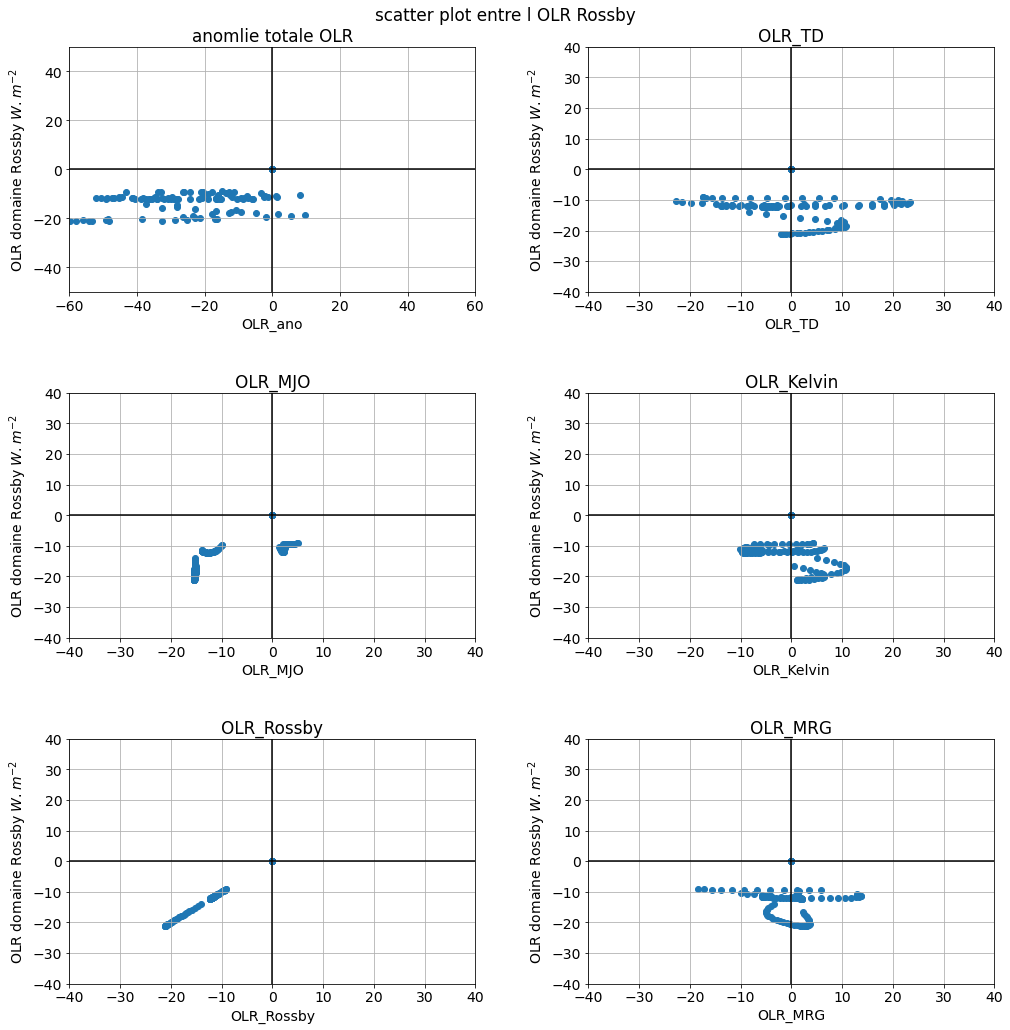

In [70]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15,15))
# _ds_FILTER_mean = ds_FILTER_mean.sel(level = 850)
variable = ['MJO','TD','Kelvin','Rossby','MRG']
plt.rc("figure", figsize=(12,10))
ds2.plot.scatter(ax=axes[0, 0], x = 'OLR_ano', y = wave_Ref)
axes[0,0].set_ylabel('OLR domaine ' + _wave + ' $W.m^{-2}$')
axes[0,0].set_label('anomalie totale OLR $m.s^{-1}$')
axes[0,0].hlines(0, -250, 100, colors = 'black')
axes[0,0].vlines(0, -55, 55, colors = 'black')
axes[0,0].set_title('anomlie totale OLR')
axes[0,0].set_xlim(-60,60)
axes[0,0].set_ylim(-50,50)
axes[0,0].grid()
# plt.show()

i = 1
j = 0
for w in wave_OLR :
    ds2.plot.scatter(ax=axes[j, i], x = w, y = wave_Ref)
    axes[j,i].set_ylabel('OLR domaine ' + _wave + ' $W.m^{-2}$')
    axes[j,i].set_label('anomalie totale u $m.s^{-1}$')
    axes[j,i].hlines(0, -250, 100, colors = 'black')
    axes[j,i].vlines(0, -55, 55, colors = 'black')
    axes[j,i].set_title(w )
    axes[j,i].set_xlim(-40,40)
    axes[j,i].set_ylim(-40,40)
    axes[j,i].grid()
    i = i + 1
    if i%2 == 0:
        i = 0
        j = j + 1
        
fig.tight_layout(pad=3.0)
plt.suptitle('scatter plot entre l OLR ' + _wave)

Text(0.5, 0.98, 'scatter plot entre l OLR Rossby')

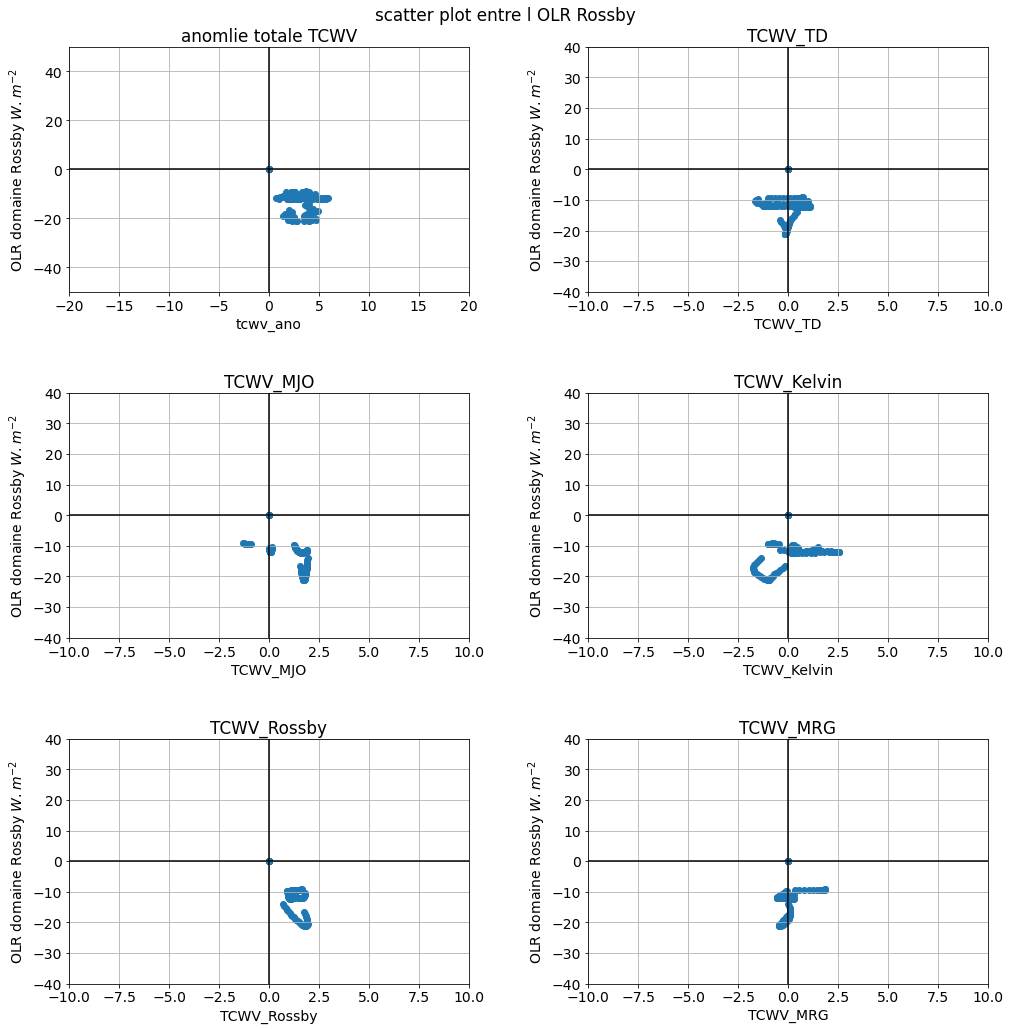

In [69]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15,15))
# _ds_FILTER_mean = ds_FILTER_mean.sel(level = 850)
variable = ['MJO','TD','Kelvin','Rossby','MRG']
plt.rc("figure", figsize=(12,10))
ds2.plot.scatter(ax=axes[0, 0], x = 'tcwv_ano', y = 'OLR_Rossby')
axes[0,0].set_ylabel('OLR domaine Rossby $W.m^{-2}$')
axes[0,0].set_label('anomalie totale TCWV $m.s^{-1}$')
axes[0,0].hlines(0, -250, 100, colors = 'black')
axes[0,0].vlines(0, -55, 55, colors = 'black')
axes[0,0].set_title('anomlie totale TCWV')
axes[0,0].set_xlim(-20,20)
axes[0,0].set_ylim(-50,50)
axes[0,0].grid()
# plt.show()

i = 1
j = 0
for w in wave_TCWV :
    ds2.plot.scatter(ax=axes[j, i], x = w, y = 'OLR_Rossby')
    axes[j,i].set_ylabel('OLR domaine Rossby $W.m^{-2}$')
    axes[j,i].set_label('anomalie totale TCWV $m.s^{-1}$')
    axes[j,i].hlines(0, -250, 100, colors = 'black')
    axes[j,i].vlines(0, -55, 55, colors = 'black')
    axes[j,i].set_title(w )
    axes[j,i].set_xlim(-10,10)
    axes[j,i].set_ylim(-40,40)
    axes[j,i].grid()
    i = i + 1
    if i%2 == 0:
        i = 0
        j = j + 1
        
fig.tight_layout(pad=3.0)
plt.suptitle('scatter plot entre l OLR ' + _wave)